In [1]:
CODE_ROOT = pwd() * "/"

include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")
include(CODE_ROOT * "mode_init/exactsolutions.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean_CUDA.jl")

update_ssh_by_tendency_cuda_kernel! (generic function with 1 method)

In [2]:
using BenchmarkTools
using DelimitedFiles
using Dates

In [6]:
function gpucpuperftest(nCellsX, nSamples=10, nSteps=10, device="CPU", showplots=false, writedata=false)
    fpath = CODE_ROOT * "output/asrock/serial$(device)_timing/coastal_kelvinwave/steps_$nSteps/resolution_$(nCellsX)x$(nCellsX)/"
    fname = "$fpath$(Dates.now()).txt"
    if writedata
        mkpath(fpath)
        println("output file: $fname")
    end
    
    mpasOcean = MPAS_Ocean(CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
        "culled_mesh_$nCellsX.nc", "mesh_$nCellsX.nc", periodicity="NonPeriodic_x", nvlevels=1)
    device_step_function! = forward_backward_step!
    
    xcell = Array(mpasOcean.xCell)
    ycell = Array(mpasOcean.yCell)
    
    etaHat, f0, kX, kY, omega = inertiaGravityWaveParams(mpasOcean, 1, 2, 1e-2)
    
    exacttime = 0.0
    inertiaGravityExactSolution!(mpasOcean, etaHat, f0, kX, kY, omega, exacttime)
    
    if showplots
        fig, ax, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
        display(fig)
    end
    
    if "GPU" == device
        mpasOcean = MPAS_Ocean_CUDA(mpasOcean)
        device_step_function! = forward_backward_step_cuda!
    end
    
    sampletimes = zeros(Float64, nSamples)
    
    for s in 1:nSamples
        sampletimes[s] += @elapsed begin for j in 1:nSteps
                device_step_function!(mpasOcean)
                exacttime += mpasOcean.dt
            end
        end
    end
    
    println("calculating error")
    exactSSH = zeros(Float64, mpasOcean.nCells)
    for iCell in 1:mpasOcean.nCells
        exactSSH[iCell] = DetermineInertiaGravityWaveExactSurfaceElevation(etaHat, kX, kY, omega, xcell[iCell], ycell[iCell], exacttime)
    end
    
    error =  sum( ( Array(mpasOcean.sshCurrent) .- exactSSH ) .^ 2 )
    
    if writedata
        open(fname, "w") do io
            writedlm(io, sampletimes)
        end
    end
    
    return sampletimes, error
end

gpucpuperftest (generic function with 8 methods)

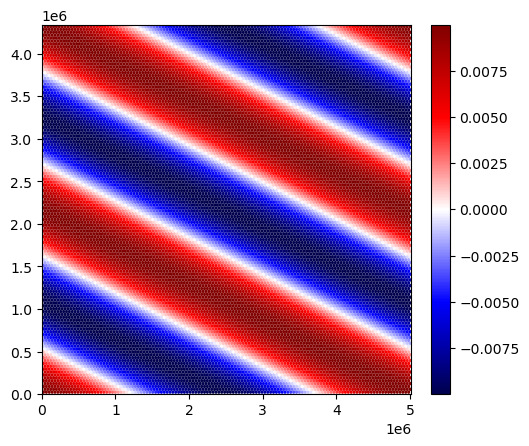

output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialCPU_timing/coastal_kelvinwave/steps_10/resolution_128x128/2022-09-07T13:12:28.475.txt
calculating error


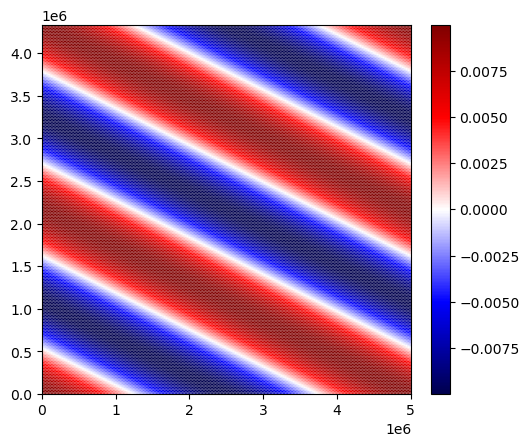

wallclock [0.080822094, 0.078762401, 0.078633263, 0.078649214, 0.078738177, 0.078769638, 0.078563898, 0.078820103, 0.078496978, 0.078806246]
error 0.014143481221200693
output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialCPU_timing/coastal_kelvinwave/steps_10/resolution_256x256/2022-09-07T13:12:35.747.txt


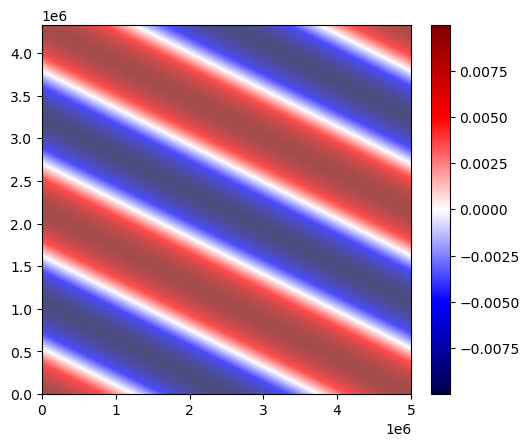

calculating error
wallclock [0.345270004, 0.344869655, 0.349410783, 0.349601164, 0.34293908, 0.3454925, 0.344277529, 0.340671376, 0.346207346, 0.34520212]
error 0.008768330146775642
output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialCPU_timing/coastal_kelvinwave/steps_10/resolution_512x512/2022-09-07T13:12:45.673.txt
calculating error
wallclock [3.160209634, 3.113520446, 3.139552619, 3.199469902, 3.088639097, 3.159879833, 3.079948729, 3.236377652, 3.117294182, 3.121519287]
error 0.00462763481009712


In [7]:
for nCellsX in [128, 256, 512]
    wc, err = gpucpuperftest(nCellsX, 10, 10, "CPU", true, true)
    println("wallclock $wc")
    println("error $err")
end

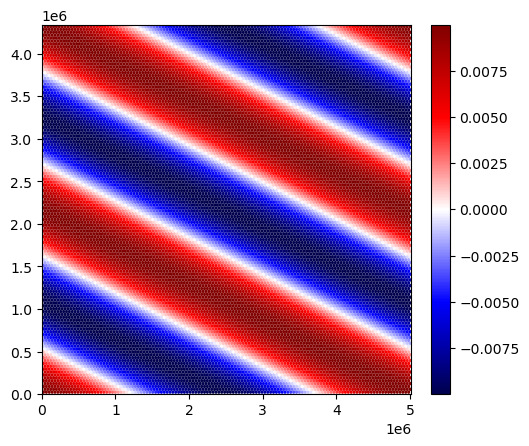

output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_10/resolution_128x128/2022-09-07T13:16:06.097.txt


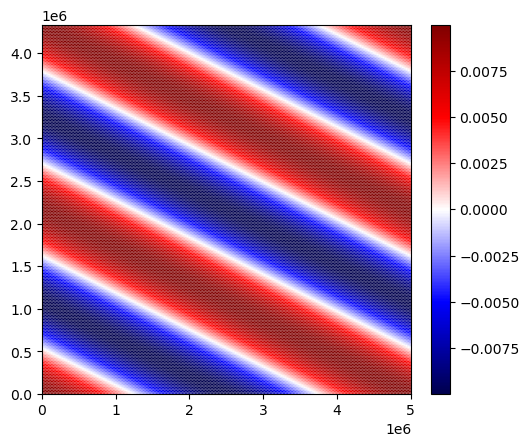

calculating error
wallclock [9.1576e-5, 5.9455e-5, 5.9677e-5, 6.1379e-5, 6.002e-5, 6.0343e-5, 5.998e-5, 6.0304e-5, 6.0048e-5, 5.9933e-5]
error 0.3932603361046978
output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_10/resolution_256x256/2022-09-07T13:16:07.663.txt
calculating error


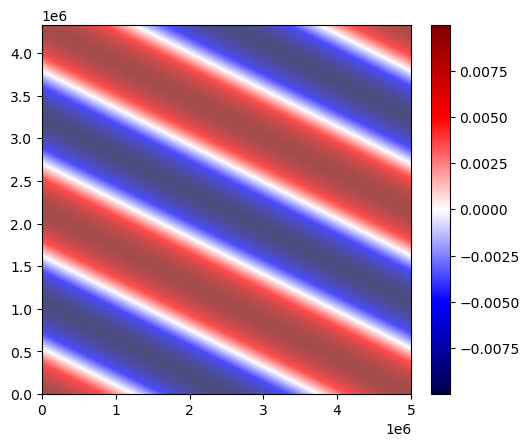

wallclock [8.9727e-5, 6.4397e-5, 5.9419e-5, 6.0958e-5, 6.0534e-5, 6.0766e-5, 6.1159e-5, 6.0822e-5, 6.2203e-5, 6.1215e-5]
error 0.20208083763025986
output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_10/resolution_512x512/2022-09-07T13:16:14.010.txt
calculating error
wallclock [9.705e-5, 6.0542e-5, 6.0556e-5, 6.1324e-5, 6.013e-5, 6.1609e-5, 6.0533e-5, 6.1888e-5, 6.0334e-5, 6.1351e-5]
error 0.09886796753487503


In [12]:
for nCellsX in [128, 256, 512]
    wc, err = gpucpuperftest(nCellsX, 10, 10, "GPU", true, true)
    println("wallclock $wc")
    println("error $err")
end

the data copying step is actually 2 - 5 times slower than it is on the CPU! Memory is the bottleneck of the GPU